<a href="https://colab.research.google.com/github/xslittlemaggie/Deep-Learning-Projects/blob/master/Objection%20(car)_Detection%20%26%20Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 0: Import libraries

In [1]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image

# graphs
% matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import random
import cv2
import os
import glob

Using TensorFlow backend.


## Step1: Upload data

#### 1.1 read data from google drive (slow) 
Whenever I make changes to the data, this will also change the data from the google drive. This is not what I want.

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#### 1.2 Copy data from google drive to colab

In [0]:
# Copy data from google drive to Colab
!cp -r "/content/drive/My Drive/Deep Learning projects/Segmentation_zip/training_data_part.zip" "/content"
!cp -r "/content/drive/My Drive/Deep Learning projects/Segmentation_zip/_out_test_crop_800_256.zip" "/content"

In [0]:
!unzip -q /content/_out_test_crop_800_256.zip -d /content/_out_test_crop_800_256/
!unzip -q /content/training_data_part.zip -d /content/training_data/

## Step 1: Get familar with the data & visualize the images

#### 1.1 visualize one image with the corresponding labelled image

The original image


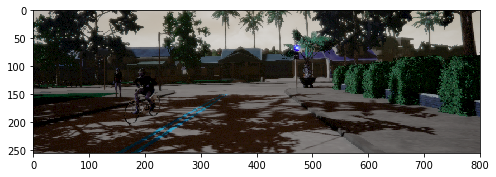

The ground truth


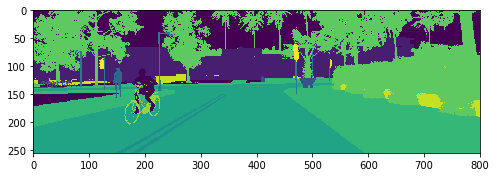

In [5]:
#fig = plt.figure(figsize = (8, 6))
img_RGB = "/content/_out_test_crop_800_256/_out_test_crop_800_256/episode_0000/CameraRGB/000030.png"
img_Seg = "/content/_out_test_crop_800_256/_out_test_crop_800_256/episode_0000/CameraSeg/000030.png"
img_RGB_array = cv2.imread(img_RGB)
img_Seg_array = cv2.imread(img_Seg)
plt.rcParams['figure.figsize'] = (8, 8)
plt.imshow(img_RGB_array)
print("The original image")
plt.show()
plt.imshow(img_Seg_array[:, :, 0])
print("The ground truth")
plt.show() 
 

## Step 2: Create training, validation, testing files to store images and masks respectively

### 2.1 Create the global file **segmentation** and the sub files

- segmentation/train_dataset
  - train_dataset/imgs
    - imgs/data
  - train_dataset/labels
    - labels/data

- segmentation/val_dataset
  - val_dataset/imgs
    - imgs/data
  - val_dataset/labels
    - labels/data

- segmentation/test_dataset
  - test_dataset/imgs
    - imgs/data
  - test_dataset/labels
    - labels/data



In [0]:
# create two files, x_train, y_train to store the original images and labels
os.mkdir("/content/segmentation")
os.mkdir("/content/segmentation/train_dataset")
os.mkdir("/content/segmentation/val_dataset")
os.mkdir("/content/segmentation/test_dataset")

In [0]:
os.mkdir("/content/segmentation/train_dataset/imgs/")
os.mkdir("/content/segmentation/train_dataset/labels/")
os.mkdir("/content/segmentation/val_dataset/imgs/")
os.mkdir("/content/segmentation/val_dataset/labels/")
os.mkdir("/content/segmentation/test_dataset/imgs/")
os.mkdir("/content/segmentation/test_dataset/labels/")

In [0]:
os.mkdir("/content/segmentation/train_dataset/imgs/data/")
os.mkdir("/content/segmentation/train_dataset/labels/data/")
os.mkdir("/content/segmentation/val_dataset/imgs/data/")
os.mkdir("/content/segmentation/val_dataset/labels/data/")
os.mkdir("/content/segmentation/test_dataset/imgs/data/")
os.mkdir("/content/segmentation/test_dataset/labels/data/")

### 2.2 Move all images and labels to the corresponding training file

- Move all training images to train_dataset/imgs/data
- Move all training labels to train_dataset/labels/data



In [0]:
# move all RGB images from 800_256_to test_imgs
episodes = ["0000/", "0001/", "0002/", "0003/", "0004/", "0005/", "0006/", "0007/", "0008/", "0009/", "0010/", "0011/", "0012/", "0013/", "0014/"]
for episode in episodes:
  pathes = glob.glob("/content/training_data/training_data_part/episode_" + episode + "CameraRGB/*.png")
  for path in pathes:
    img_array = cv2.imread(path)
    try:
      img_array/255
    except:
      print(path)
      break
    head, tail = os.path.split(path)
    new_path = "/content/segmentation/train_dataset/imgs/data/" + head[-22:-10] + "_RGB_" + tail
    os.rename(path, new_path)
    #print(new_path)

In [0]:
# move all RGB images from 800_256_to test_imgs
episodes = ["0000/", "0001/", "0002/", "0003/", "0004/", "0005/", "0006/", "0007/", "0008/", "0009/", "0010/", "0011/", "0012/", "0013/", "0014/"]
for episode in episodes:
  pathes = glob.glob("/content/training_data/training_data_part/episode_" + episode + "CameraSeg/*.png")
  for path in pathes:
    img_array = cv2.imread(path)
    try:
      img_array/255
    except:
      print(path)
      break
    head, tail = os.path.split(path)
    new_path = "/content/segmentation/train_dataset/labels/data/" + head[-22:-10] + "_Seg_" + tail
    os.rename(path, new_path)
    #print(new_path)

### 2.3 Move all images and labels to the corresponding testing file
- Move all testing images to test_dataset/imgs/data
- Move all testing labels to test_dataset/labels/data

In [0]:
# move all RGB images from 800_256_to test_imgs
episodes = ["0000/", "0001/", "0002/", "0003/", "0004/", "0005/", "0006/", "0007/", "0008/", "0009/", "0010/", "0011/", "0012/", "0013/", "0014/"]
for episode in episodes:
  pathes = glob.glob("/content/_out_test_crop_800_256/_out_test_crop_800_256/episode_" + episode + "CameraRGB/*.png")
  for path in pathes:
    img_array = cv2.imread(path)
    try:
      img_array/255
    except:
      print(path)
      break
    head, tail = os.path.split(path)
    new_path = "/content/segmentation/test_dataset/imgs/data/" + head[-22:-10] + "_RGB_" + tail
    os.rename(path, new_path)
    #print(new_path)

In [0]:
# move all RGB images from 800_256_to test_imgs
episodes = ["0000/", "0001/", "0002/", "0003/", "0004/", "0005/", "0006/", "0007/", "0008/", "0009/", "0010/", "0011/", "0012/", "0013/", "0014/"]
for episode in episodes:
  pathes = glob.glob("/content/_out_test_crop_800_256/_out_test_crop_800_256/episode_" + episode + "CameraSeg/*.png")
  for path in pathes:
    img_array = cv2.imread(path)
    try:
      img_array/255
    except:
      print(path)
      break
    head, tail = os.path.split(path)
    new_path = "/content/segmentation/test_dataset/labels/data/" + head[-22:-10] + "_Seg_" + tail
    os.rename(path, new_path)
    #print(new_path)

### 2.4 About the final training data

In [13]:
dir_train_images = '/content/segmentation/train_dataset/imgs/data'
dir_train_labels = '/content/segmentation/train_dataset/labels/data'

dir_train_images_fname = os.listdir(dir_train_images)
dir_train_labels_fname = os.listdir(dir_train_labels)

print("Total training images:", len(dir_train_images_fname))
print("Total training labels:", len(dir_train_labels_fname))

Total training images: 2700
Total training labels: 2700


### 2.5 About the final testing data

In [14]:
dir_test_images = '/content/segmentation/test_dataset/imgs/data'
dir_test_labels = '/content/segmentation/test_dataset/labels/data'

dir_test_images_fname = os.listdir(dir_test_images)
dir_test_labels_fname = os.listdir(dir_test_labels)

print("Total training images:", len(dir_test_images_fname))
print("Total training labels:", len(dir_test_labels_fname))

Total training images: 2400
Total training labels: 2400


### 2.6 Image visualization after organizing the training, validation, and testing files

(256, 800, 3)


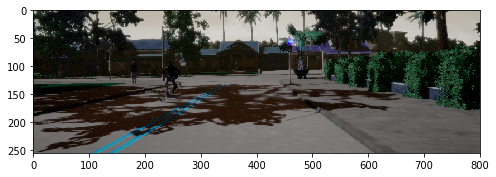

In [15]:
# the first image from testing dataset
tmp = cv2.imread('/content/segmentation/test_dataset/imgs/data/episode_0000_RGB_000020.png')
print(tmp.shape)
plt.imshow(tmp)
plt.show()

(256, 800, 3)


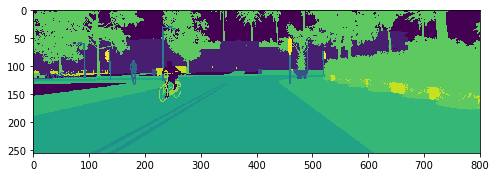

In [16]:
# the first ground truth from the testing dataset
tmp = cv2.imread('/content/segmentation/test_dataset/labels/data/episode_0000_Seg_000020.png')
print(tmp.shape)
plt.imshow(tmp[:, :, 0])
plt.show()

## Step 3: Data Generator Preprocessing

In [17]:
# Creating the training Image and Mask generator

batch_size = 4
seed = 1

train_datagen = ImageDataGenerator(rescale = 1/255.) 

train_image_generator = train_datagen.flow_from_directory("/content/segmentation/train_dataset/imgs", 
                       batch_size = batch_size, target_size = (256, 800), class_mode=None, seed = seed) # target_size = (img_size, img_size), shuffle = True

train_mask_generator = train_datagen.flow_from_directory("/content/segmentation/train_dataset/labels", 
                       batch_size = batch_size, target_size = (256, 800),color_mode = "grayscale", class_mode=None, seed = seed) # target_size = (img_size, img_size), shuffle = True

# Creating the validation Image and Mask generator
val_datagen = ImageDataGenerator(rescale = 1/255.)

val_image_generator = val_datagen.flow_from_directory("/content/segmentation/val_dataset/imgs",
                      batch_size = batch_size, target_size = (256, 800), class_mode=None, seed = seed)
val_mask_generator = val_datagen.flow_from_directory("/content/segmentation/val_dataset/labels",
                      batch_size = batch_size, target_size = (256, 800), color_mode = "grayscale", class_mode=None, seed = seed)

# Creating the test Image and Mask generator
test_datagen = ImageDataGenerator(rescale = 1/255.) 
test_image_generator = test_datagen.flow_from_directory("/content/segmentation/test_dataset/imgs",
                      batch_size = batch_size, target_size = (256, 800), class_mode=None, seed = seed)

test_mask_generator = test_datagen.flow_from_directory("/content/segmentation/test_dataset/labels",
                      batch_size = batch_size, target_size = (256, 800), color_mode = "grayscale", class_mode=None, seed = seed)


train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)
test_generator = zip(test_image_generator, test_mask_generator)

Found 2700 images belonging to 1 classes.
Found 2700 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Found 2400 images belonging to 1 classes.
Found 2400 images belonging to 1 classes.


(4, 256, 800, 3)


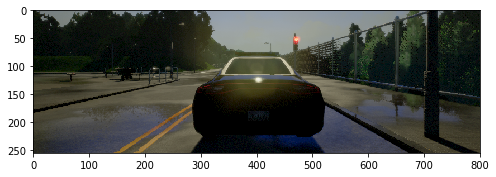

(4, 256, 800, 1)


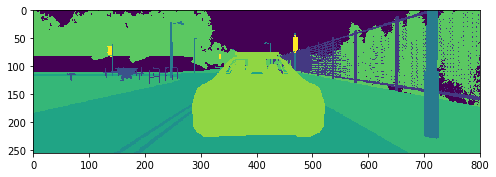

In [18]:
# check generator
for img in test_generator:
  print(img[0].shape)
  plt.imshow(img[0][0])
  plt.show()
  print(img[1].shape)
  plt.imshow(img[1][0][:, :, 0])
  plt.show()
  break

In [19]:
# check training generator
count = 0
for x,y in train_generator:
  count += 1
  print(x.shape, y.shape)
  print(count)
  break
  if count % 100 == 0:
    print(count)

(4, 256, 800, 3) (4, 256, 800, 1)
1


In [20]:
# check testing generator
count = 0
for x,y in test_generator:
  count += 1
  print(x.shape, y.shape)
  print(count)
  break
  if count % 100 == 0:
    print(count)

(4, 256, 800, 3) (4, 256, 800, 1)
1


#### Creating data generator

In [0]:
def data_gen(img_folder, mask_folder, batch_size):
  c = 0
  n = os.listdir(img_folder) # List of training images
  random.shuffle(n)
  
  while (True):
    img = np.zeros((batch_size, 256, 800, 3)).astype('float')
    mask = np.zeros((batch_size, 256, 800, 1)).astype('float')
    
    for i in range(c, c + batch_size): # initially from 0 to 16, c = 0
      train_img = cv2.imread(img_folder + '/' + n[i])/255.
      #train_img = cv2.resize(train_img, (512, 512)) # Read an image from folder and resize the image
      
      img[i-c] = train_img # add to array -img[0], img[1], and so on
      
      train_mask = cv2.imread(mask_folder + '/' + n[i], cv2.IMREAD_GRAYSCALE)/255.
      #train_mask = cv2.resize(train_mask, (512, 512))
      train_mask = train_mask.reshape(256, 800, 1) # Add extra dimension for the parity with train_img
      
      mask[i-c] = train_mask
      
    c += batch_size
    if (c + batch_size >= len(os.listdir(img_folder))):
      c = 0
      random.shuffle(n)
    yield img, mask
    
train_frame_path = '/content/segmentation/train_dataset/imgs/data' 
train_mask_path = '/content/segmentation/train_dataset/labels/data' 

val_frame_path = '/content/segmentation/test_dataset/imgs/data' 
val_mask_path = '/content/segmentation/test_dataset/labels/data'

# train the model
train_gen = data_gen(train_frame_path, train_mask_path, batch_size = 4)
val_gen = data_gen(val_frame_path, val_mask_path, batch_size = 4)

## Step 3: Prepare for the U-Net Model

#### 3.1 Model creation

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [24]:
im_height = 256
im_width = 800

input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.3, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 800, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 800, 16) 64          conv2d_1[0][0]                   
_________________________________________________________________________

#### 3.2 Model visualization

In [0]:
from keras.utils import plot_model
#plot_model(model, to_file='model.png')

#### 3.3 Model fitting/training

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=30, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-car-detection.h5', verbose=1, save_best_only=True, save_weights_only=True)]

In [27]:
#steps_per_epoch = train_image_generator.n//train_image_generator.batch_size
#validation_steps = val_image_generator.n//val_image_generator.batch_size

history = model.fit_generator(train_generator, 
                              epochs = 100, 
                              steps_per_epoch = 35,  # number of training_images / batch_size
                              validation_data =test_generator,
                              validation_steps = 7)

model.save('model-car-detection.h5')

Epoch 1/100
35/35 [==============================] - 27s 785ms/step - loss: 0.7927 - acc: 0.0744 - val_loss: 0.5824 - val_acc: 0.1444
Epoch 2/100
35/35 [==============================] - 14s 406ms/step - loss: 0.4515 - acc: 0.1391 - val_loss: 0.6243 - val_acc: 0.1231
Epoch 3/100
35/35 [==============================] - 14s 407ms/step - loss: 0.3587 - acc: 0.1470 - val_loss: 0.3365 - val_acc: 0.1819
Epoch 4/100
35/35 [==============================] - 14s 408ms/step - loss: 0.3069 - acc: 0.1344 - val_loss: 0.2980 - val_acc: 0.1426
Epoch 5/100
35/35 [==============================] - 14s 408ms/step - loss: 0.2643 - acc: 0.1388 - val_loss: 0.2683 - val_acc: 0.1700
Epoch 6/100
35/35 [==============================] - 14s 405ms/step - loss: 0.2316 - acc: 0.1402 - val_loss: 0.2382 - val_acc: 0.1503
Epoch 7/100
35/35 [==============================] - 14s 406ms/step - loss: 0.2027 - acc: 0.1385 - val_loss: 0.2216 - val_acc: 0.1772
Epoch 8/100
35/35 [==============================] - 14s 408ms

## Step 4: Model accuracy & loss analysis

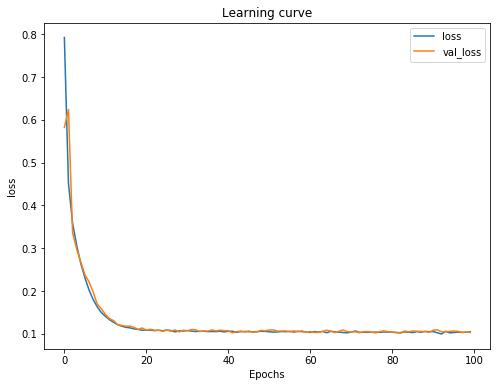

In [28]:
plt.figure(figsize=(8, 6))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

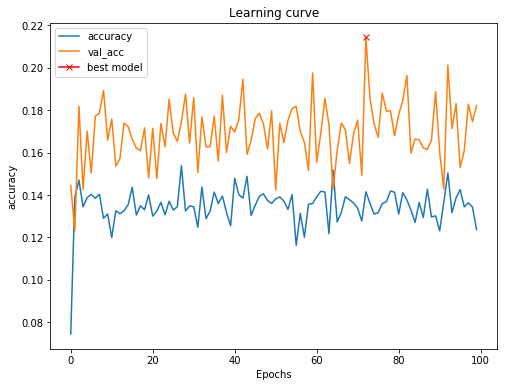

In [29]:
plt.figure(figsize=(8, 6))
plt.title("Learning curve")
plt.plot(history.history["acc"], label="accuracy")
plt.plot(history.history["val_acc"], label="val_acc")
plt.plot( np.argmax(history.history["val_acc"]), np.max(history.history["val_acc"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## Step 5: Prediction

In [0]:
# Load best model
model.load_weights('model-car-detection.h5')

In [31]:
"""
# Predict on train, val and test
preds_train = model.predict_generator(train_image_generator, steps = train_image_generator.n, verbose=1)
preds_val = model.predict_generator(val_image_generator, steps = val_image_generator.n, verbose=1)
preds_test = model.predict_generator(test_image_generator, steps = test_image_generator.n, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_val > 0.5).astype(np.uint8)
"""

'\n# Predict on train, val and test\npreds_train = model.predict_generator(train_image_generator, steps = train_image_generator.n, verbose=1)\npreds_val = model.predict_generator(val_image_generator, steps = val_image_generator.n, verbose=1)\npreds_test = model.predict_generator(test_image_generator, steps = test_image_generator.n, verbose=1)\n\n# Threshold predictions\npreds_train_t = (preds_train > 0.5).astype(np.uint8)\npreds_val_t = (preds_val > 0.5).astype(np.uint8)\npreds_test_t = (preds_val > 0.5).astype(np.uint8)\n'

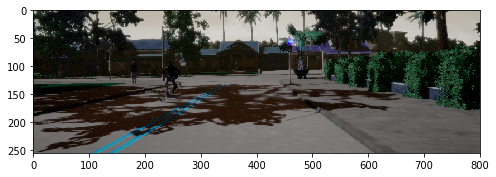

In [32]:
# True image
img = "/content/segmentation/test_dataset/imgs/data/episode_0000_RGB_000020.png"
img_array = cv2.imread(img)
plt.imshow(img_array)
plt.show()

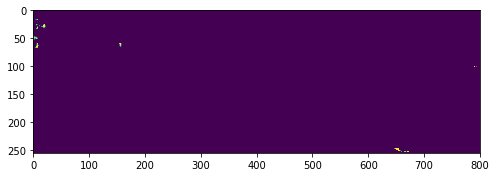

In [38]:
# predicted
#plt.figure(figsize = (12, 8))
img = "/content/segmentation/test_dataset/imgs/data/episode_0000_RGB_000020.png"
img_array = cv2.imread(img)
res = model.predict(np.array([img_array]))
plt.imshow(res[0][:,:, 0])
plt.show()


The ground truth


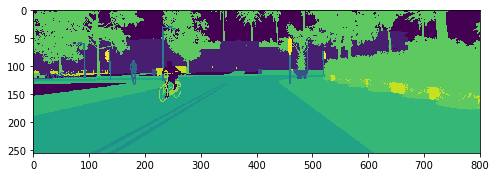

In [34]:
# ground Truth
img = "/content/segmentation/test_dataset/labels/data/episode_0000_Seg_000020.png"
img_array = cv2.imread(img)
plt.imshow(img_array[:, :, 0])
print("The ground truth")
plt.show()

## Useful reference
URL_1 = "https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a"

URL_2 = "https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/"

URL_3 = "https://tryolabs.com/blog/2017/08/30/object-detection-an-overview-in-the-age-of-deep-learning/" **(include datasets)**

URL_4 = "https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/"

URL_5 = "https://towardsdatascience.com/deep-learning-for-object-detection-a-comprehensive-review-73930816d8d9" **(Deep learning for object Detection)**

URL_6 = "https://towardsdatascience.com/deep-learning-for-object-detection-a-comprehensive-review-73930816d8d9"

URL_7 = "https://www.depends-on-the-definition.com/unet-keras-segmenting-images/" **(unet model)**

URL_8 = "https://towardsdatascience.com/a-keras-pipeline-for-image-segmentation-part-1-6515a421157d" **(model with ImageDataGenerator)**